In [6]:
from qiskit import QuantumCircuit, QuantumRegister, BasicAer, IBMQ, execute

from qiskit.quantum_info import *

from qiskit.circuit import Parameter

from qiskit.ignis.verification import *

from qiskit.tools.monitor import job_monitor

import matplotlib.pyplot as plt
%matplotlib inline

%config InlineBackend.figure_format = 'svg'

from math import pi
import numpy as np

from qiskit.providers.ibmq import least_busy

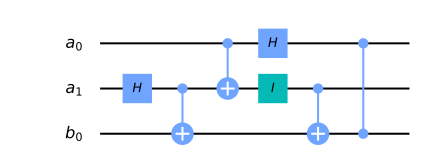

In [13]:
a = QuantumRegister(2, name='a')
b = QuantumRegister(1, name='b')

circuit = QuantumCircuit(a,b)
circuit.h(1)
circuit.cx(1,2)
circuit.cx(0,1)
circuit.h(0)
circuit.id(1)
circuit.cx(1,2)
circuit.cz(0,2)

circuit.draw(output='mpl')

In [7]:
account = IBMQ.load_account()

In [14]:
circuits = process_tomography_circuits(circuit, b, a[0])

provider = IBMQ.get_provider('ibm-q')
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
j = execute(circuits, backend=backend, shots=8192)
job_monitor(j)

Job Status: job has successfully run


In [16]:

#results = execute(circuits, shots=10000, backend=backend).result()

fitter = ProcessTomographyFitter(j.result(), circuits)

chi_ex = fitter.fit().data # experimental

In [17]:
#rho: density matrix 2X2
#chi: process matrix 4X4
def superoperator(rho, chi):
    return [[rho[0][0]*chi[0][0] + rho[0][1]*chi[0][1] + rho[1][0]*chi[1][0] + rho[1][1]*chi[1][1],
            rho[0][0]*chi[0][2] + rho[0][1]*chi[0][3] + rho[1][0]*chi[1][2] + rho[1][1]*chi[1][3]],
           [rho[0][0]*chi[2][0] + rho[0][1]*chi[2][1] + rho[1][0]*chi[3][0] + rho[1][1]*chi[3][1],
            rho[0][0]*chi[2][2] + rho[0][1]*chi[2][3] + rho[1][0]*chi[3][2] + rho[1][1]*chi[3][3]]]

In [65]:
def vec_to_rho(x, y, z):
    return 0.5 * np.array([[1.0 + z, complex(x, -y)], [complex(x, y), 1.0 - z]])

def rho_to_vec(rho):
    x = 2*rho[0][1].real
    y = 2*rho[1][0].imag
    z = (rho[0][0] - rho[1][1]).real
    return [x, y, z]

In [70]:
rho = vec_to_rho(0, 0, 1)
out = superoperator(rho, chi_ex)
print(rho_to_vec(out), '\n')

rho = vec_to_rho(1, 0, 0)
out = superoperator(rho, chi_ex)
print(rho_to_vec(out), '\n')

rho = vec_to_rho(1/np.sqrt(2), 1/np.sqrt(6), 1/np.sqrt(3))
out = superoperator(rho, chi_ex)
print(rho_to_vec(out), '\n')

[0.05078125000000114, -0.015625000000001395, 0.7907714843750007] 

[0.8114013671875003, -0.059936523437500916, 0.019165039062500167] 

[0.6584824933503036, 0.2599664373534349, 0.4546550095718859] 

